## Fidelities with Common Randomized Measurements

With common randomized measurements [Vermersch, al, PRXQ 2024](https://doi.org/10.1103/PRXQuantum.5.010352), a classical approximation $\sigma$ of an experimental state $\rho$ is used to facilitate the measurement of physical properties. 

In this tutorial, we will illustrate in the context of the measurement of the fidelity $\mathcal{F}=\mathrm{Tr}(\rho \sigma)$, where $\sigma=\ket{\psi}\bra{\psi}$.

Note that in this example,  $\sigma$ is at the same time the observable we are interested in, and the classical approximation we used for building common randomized measurements.

In [1]:
using ProgressMeter
using RandomMeas

We begin by considering $\sigma=\ket{\psi}\bra{\psi}$ ($\rho$) as the output of an ideal (noisy, respectively) $2$-qubit quantum circuit of various depths $d$

In [2]:
N = 2
depth = 5
cutoff = 1e-4
ξ = siteinds("Qubit", N)
ψ,ρ,F = MPS[], MPO[], Float64[]

#initial states
push!(ψ,MPS(ξ, ["Dn" for n in 1:N]));
push!(ρ,outer(ψ[1]',ψ[1]));
push!(F,1.)

#random circuit and noise parameters
circuit = random_circuit(ξ,depth)
p = 0.1*rand(N)
@showprogress dt=1 for d in 1:depth
            push!(ψ,apply(circuit,ψ[d];cutoff=cutoff))
            ρt = apply(circuit,ρ[d],apply_dag=true;cutoff=cutoff)
            #each random circuit layer is followed by local depolarization with probabilities p 
            push!(ρ,apply_depo_channel(ρt,p));  

            push!(F,real(inner(ψ[d+1]',ρ[d+1],ψ[d+1])))
end


Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


We first perform randomized measurement on the experimental state, and store the unitaries $u$ that we used

In [3]:
#Perform Randomized measurements
NU=1000
NM=1000

measurement_settings = sample_local_random_unitaries(N,NU,site_indices = ξ);

measurement_data = Vector{MeasurementData}(undef,depth+1)
for d in 1:depth+1
    measurement_data[d] = simulate_local_measurements(ρ[d],NM, mode="dense", measurement_settings=measurement_settings);
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


From randomized measurement, we know that we can build estimate the fidelity $\mathcal{F}$ as $\mathcal{F}_e=\mathrm{tr}(\sigma \hat{\rho})$ with the shadows $\hat{\rho}$. 

In [4]:
F_e = zeros(Float64,depth+1)
for d in 1:depth+1
    shadow_d = get_dense_shadows(measurement_data[d])
    F_e[d] = real(get_expect_shadow(outer(ψ[d]',ψ[d]),shadow_d))
end

F_e = [1.0036012791788573, 0.982404260172937, 0.917817762469148, 0.9106881286953357, 0.8500857290692934, 0.8156185666150843]


6-element Vector{Float64}:
 1.0036012791788573
 0.982404260172937
 0.917817762469148
 0.9106881286953357
 0.8500857290692934
 0.8156185666150843

CRM provide a more efficient estimator $\mathcal{F}_{CRM}=\mathrm{tr}(\sigma \hat{\rho})-\mathrm{tr}(\sigma \hat{\sigma})+1$ based on  using the simulated shadow $\hat{\sigma}$, which is generated numerically from the Born probabilities $P_0(s)=\langle s|u\sigma u^\dag|s\rangle$.

In [5]:
F_CRM = copy(F_e).+1
u = measurement_settings.local_unitaries

#Perform simulated Randomized measurements
for d in 1:depth+1
    ψ_f = flatten(ψ[d])
    @showprogress dt=1 for r in 1:NU
                    P = get_Born(apply(u[r,:],ψ[d]))
                    shadow_sigma = DenseShadow(P, u[r,:])
                    F_CRM[d] -= real(get_expect_shadow(outer(ψ[d]',ψ[d]),shadow_sigma))/NU
    end
end

#TODO: Shall we add a data structure MeasurementProbabilities to store the probabilities of each measurement outcome for all measurement settings? 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


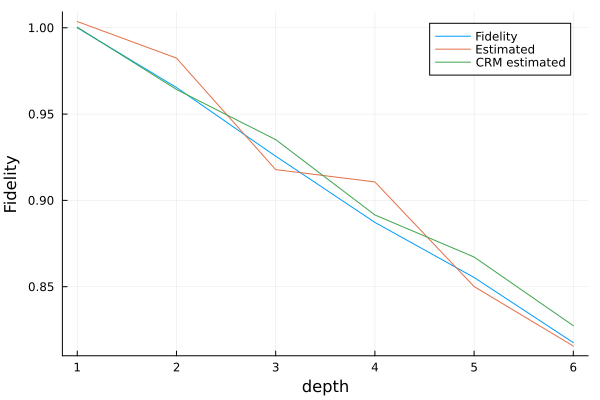

In [6]:
using Plots
Plots.plot(1:depth+1,F,label="Fidelity")
plot!(1:depth+1,F_e,label="Estimated")
plot!(1:depth+1,F_CRM,label="CRM estimated")
xlabel!("depth")
ylabel!("Fidelity")